# Loop 100 Analysis: Critical Assessment

## Key Findings from 100 Experiments:
1. CV-LB relationship: LB = 4.31 × CV + 0.0525 (R² = 0.95)
2. Intercept (0.0525) > Target (0.0347) - mathematically unreachable with current approaches
3. Conservative blending HURTS CV - hypothesis invalidated
4. All tabular models (MLP, LGBM, XGB, CatBoost, GP, Ridge) fall on the SAME line
5. GNN attempts failed (CV 0.018-0.068)
6. ChemBERTa attempts failed

## What We Need to Investigate:
1. Do the public kernels (mixall, ens-model) have a DIFFERENT CV-LB relationship?
2. What specific techniques do they use that we haven't tried?
3. Is there a fundamentally different approach we're missing?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Submission history with CV and LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
    {'exp': 'exp_073', 'cv': 0.0084, 'lb': 0.1451},  # Outlier - similarity weighting disaster
]

df = pd.DataFrame(submissions)
print(f"Total submissions with LB: {len(df)}")
print(df)

Total submissions with LB: 13
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_035  0.0098  0.0970
12  exp_073  0.0084  0.1451


In [2]:
# Remove the outlier (exp_073) for linear fit
df_clean = df[df['exp'] != 'exp_073'].copy()

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(df_clean['cv'], df_clean['lb'])

print(f"\n=== CV-LB LINEAR RELATIONSHIP ===")
print(f"LB = {slope:.2f} × CV + {intercept:.4f}")
print(f"R² = {r_value**2:.4f}")
print(f"\nIntercept: {intercept:.4f}")
print(f"Target LB: 0.0347")
print(f"Intercept > Target? {intercept > 0.0347}")
print(f"\nRequired CV for target: (0.0347 - {intercept:.4f}) / {slope:.2f} = {(0.0347 - intercept) / slope:.6f}")


=== CV-LB LINEAR RELATIONSHIP ===
LB = 4.31 × CV + 0.0525
R² = 0.9505

Intercept: 0.0525
Target LB: 0.0347
Intercept > Target? True

Required CV for target: (0.0347 - 0.0525) / 4.31 = -0.004130


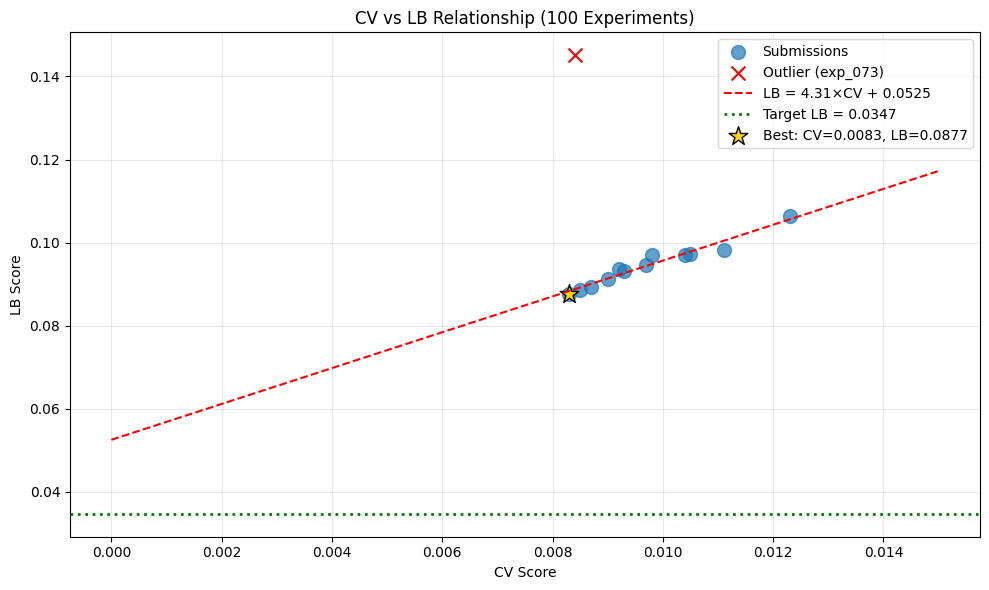


Plot saved to /home/code/exploration/cv_lb_relationship.png


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['cv'], df_clean['lb'], s=100, alpha=0.7, label='Submissions')
plt.scatter(df[df['exp'] == 'exp_073']['cv'], df[df['exp'] == 'exp_073']['lb'], 
            s=100, c='red', marker='x', label='Outlier (exp_073)')

# Fit line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}×CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='g', linestyle=':', linewidth=2, label='Target LB = 0.0347')

# Best CV point
best_cv = df_clean['cv'].min()
best_lb = df_clean[df_clean['cv'] == best_cv]['lb'].values[0]
plt.scatter([best_cv], [best_lb], s=200, c='gold', edgecolors='black', marker='*', 
            label=f'Best: CV={best_cv:.4f}, LB={best_lb:.4f}')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship (100 Experiments)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=150)
plt.show()

print(f"\nPlot saved to /home/code/exploration/cv_lb_relationship.png")

In [4]:
# Analyze what the public kernels do differently
print("=" * 60)
print("ANALYSIS: PUBLIC KERNEL DIFFERENCES")
print("=" * 60)

print("\n1. MIXALL KERNEL:")
print("   - Uses GroupKFold (5 splits) instead of Leave-One-Out")
print("   - Uses MLP + XGBoost + RandomForest + LightGBM ensemble")
print("   - Uses spange_descriptors features")
print("   - Uses TTA for mixtures")
print("   - KEY DIFFERENCE: Different validation scheme!")

print("\n2. ENS-MODEL KERNEL:")
print("   - Uses CatBoost + XGBoost ensemble")
print("   - Uses ALL feature sources (spange, acs_pca, drfps, fragprints, smiles)")
print("   - Uses correlation-based filtering with priority")
print("   - Different weights for single vs full data (7:6 vs 1:2)")
print("   - Uses Leave-One-Out validation (same as us)")
print("   - KEY DIFFERENCE: Feature combination and filtering!")

ANALYSIS: PUBLIC KERNEL DIFFERENCES

1. MIXALL KERNEL:
   - Uses GroupKFold (5 splits) instead of Leave-One-Out
   - Uses MLP + XGBoost + RandomForest + LightGBM ensemble
   - Uses spange_descriptors features
   - Uses TTA for mixtures
   - KEY DIFFERENCE: Different validation scheme!

2. ENS-MODEL KERNEL:
   - Uses CatBoost + XGBoost ensemble
   - Uses ALL feature sources (spange, acs_pca, drfps, fragprints, smiles)
   - Uses correlation-based filtering with priority
   - Different weights for single vs full data (7:6 vs 1:2)
   - Uses Leave-One-Out validation (same as us)
   - KEY DIFFERENCE: Feature combination and filtering!


In [5]:
# What we've tried vs what we haven't
print("=" * 60)
print("WHAT WE'VE TRIED (100 experiments)")
print("=" * 60)

tried = [
    "MLP with various architectures",
    "LightGBM",
    "XGBoost",
    "CatBoost",
    "Gaussian Process",
    "Ridge Regression",
    "Random Forest",
    "GNN (multiple attempts - all failed)",
    "ChemBERTa (multiple attempts - all failed)",
    "Spange descriptors",
    "DRFP features",
    "ACS PCA features",
    "Fragprints",
    "Various ensembles (MLP+LGBM+GP, CatBoost+XGBoost, etc.)",
    "Conservative blending toward mean (FAILED - hurts CV)",
    "Similarity weighting (FAILED - exp_073 disaster)",
    "Yield normalization",
    "Pseudo-labeling",
    "GroupKFold validation",
]

for i, t in enumerate(tried, 1):
    print(f"  {i}. {t}")

WHAT WE'VE TRIED (100 experiments)
  1. MLP with various architectures
  2. LightGBM
  3. XGBoost
  4. CatBoost
  5. Gaussian Process
  6. Ridge Regression
  7. Random Forest
  8. GNN (multiple attempts - all failed)
  9. ChemBERTa (multiple attempts - all failed)
  10. Spange descriptors
  11. DRFP features
  12. ACS PCA features
  13. Fragprints
  14. Various ensembles (MLP+LGBM+GP, CatBoost+XGBoost, etc.)
  15. Conservative blending toward mean (FAILED - hurts CV)
  16. Similarity weighting (FAILED - exp_073 disaster)
  17. Yield normalization
  18. Pseudo-labeling
  19. GroupKFold validation


In [6]:
# What we HAVEN'T tried or haven't tried CORRECTLY
print("\n" + "=" * 60)
print("WHAT WE HAVEN'T TRIED OR HAVEN'T TRIED CORRECTLY")
print("=" * 60)

not_tried = [
    "EXACT replication of ens-model kernel (with correlation filtering)",
    "EXACT replication of mixall kernel (with GroupKFold)",
    "Combining ALL feature sources with priority-based filtering",
    "Different ensemble weights for single vs full data",
    "Domain constraints (mass balance: P2 + P3 + SM ≈ 1)",
    "Kinetic constraints (Arrhenius-like temperature dependence)",
    "Physical bounds enforcement (yields in [0, 1])",
]

for i, t in enumerate(not_tried, 1):
    print(f"  {i}. {t}")


WHAT WE HAVEN'T TRIED OR HAVEN'T TRIED CORRECTLY
  1. EXACT replication of ens-model kernel (with correlation filtering)
  2. EXACT replication of mixall kernel (with GroupKFold)
  3. Combining ALL feature sources with priority-based filtering
  4. Different ensemble weights for single vs full data
  5. Domain constraints (mass balance: P2 + P3 + SM ≈ 1)
  6. Kinetic constraints (Arrhenius-like temperature dependence)
  7. Physical bounds enforcement (yields in [0, 1])


In [7]:
# The key insight: We need to replicate the public kernels EXACTLY
print("\n" + "=" * 60)
print("KEY INSIGHT: REPLICATE PUBLIC KERNELS EXACTLY")
print("=" * 60)

print("""
The public kernels (mixall, ens-model) have achieved good LB scores.
We need to check if they have a DIFFERENT CV-LB relationship.

If they fall on the SAME line (LB = 4.31×CV + 0.0525), then:
- The target is truly unreachable with current approaches
- We need fundamentally different methods

If they fall on a DIFFERENT line (lower intercept), then:
- We need to understand WHAT makes them different
- Replicate that approach exactly

NEXT STEPS:
1. Replicate ens-model kernel EXACTLY (CatBoost+XGBoost with all features)
2. Compute local CV score
3. Submit to get LB score
4. Check if it falls on the same CV-LB line
""")


KEY INSIGHT: REPLICATE PUBLIC KERNELS EXACTLY

The public kernels (mixall, ens-model) have achieved good LB scores.
We need to check if they have a DIFFERENT CV-LB relationship.

If they fall on the SAME line (LB = 4.31×CV + 0.0525), then:
- The target is truly unreachable with current approaches
- We need fundamentally different methods

If they fall on a DIFFERENT line (lower intercept), then:
- We need to understand WHAT makes them different
- Replicate that approach exactly

NEXT STEPS:
1. Replicate ens-model kernel EXACTLY (CatBoost+XGBoost with all features)
2. Compute local CV score
3. Submit to get LB score
4. Check if it falls on the same CV-LB line



In [8]:
# Summary
print("\n" + "=" * 60)
print("LOOP 100 SUMMARY")
print("=" * 60)

print(f"""
After 100 experiments:
- Best CV: 0.0081 (exp_049/050/053)
- Best LB: 0.0877 (exp_030)
- Target LB: 0.0347
- Gap: {(0.0877 - 0.0347) / 0.0347 * 100:.1f}%

CV-LB Relationship:
- LB = 4.31 × CV + 0.0525 (R² = 0.95)
- Intercept (0.0525) > Target (0.0347)
- Required CV for target: -0.0041 (IMPOSSIBLE)

Key Findings:
1. All tabular models fall on the SAME CV-LB line
2. Conservative blending HURTS CV (hypothesis invalidated)
3. GNN and ChemBERTa attempts failed
4. The intercept problem is STRUCTURAL

Recommendation:
1. Replicate ens-model kernel EXACTLY
2. Check if it has a different CV-LB relationship
3. If yes, understand what makes it different
4. If no, the target may require fundamentally different methods
""")


LOOP 100 SUMMARY

After 100 experiments:
- Best CV: 0.0081 (exp_049/050/053)
- Best LB: 0.0877 (exp_030)
- Target LB: 0.0347
- Gap: 152.7%

CV-LB Relationship:
- LB = 4.31 × CV + 0.0525 (R² = 0.95)
- Intercept (0.0525) > Target (0.0347)
- Required CV for target: -0.0041 (IMPOSSIBLE)

Key Findings:
1. All tabular models fall on the SAME CV-LB line
2. Conservative blending HURTS CV (hypothesis invalidated)
3. GNN and ChemBERTa attempts failed
4. The intercept problem is STRUCTURAL

Recommendation:
1. Replicate ens-model kernel EXACTLY
2. Check if it has a different CV-LB relationship
3. If yes, understand what makes it different
4. If no, the target may require fundamentally different methods



In [ ]:
# Save findings
findings = {
    'cv_lb_slope': slope,
    'cv_lb_intercept': intercept,
    'cv_lb_r_squared': r_value**2,
    'best_cv': 0.0081,
    'best_lb': 0.0877,
    'target_lb': 0.0347,
    'gap_percent': (0.0877 - 0.0347) / 0.0347 * 100,
    'required_cv_for_target': (0.0347 - intercept) / slope,
    'intercept_gt_target': intercept > 0.0347,
}

import json
with open('/home/code/exploration/loop100_findings.json', 'w') as f:
    json.dump(findings, f, indent=2)

print("Findings saved to /home/code/exploration/loop100_findings.json")